In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.layers import *
from keras.layers.merge import *
from keras.initializers import *
from keras.models import Model

In [0]:
from keras.optimizers import *
from keras.initializers import *
from keras.layers import *
from keras.layers.merge import *
from keras.models import *

residual_convolution_options = dict({
    'dropout_mode': 'spatial',
    'dropout_rate': 0.2,
    'filters': 300,
    'kernel_size': 1,
    'strides': 1,
    'padding': 'same',
    'activation': 'elu',
    'should_preactivate': True
})

def convolution_block(input_layer, options):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    convolution_block = convolution_input

    if(options['should_preactivate']):
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
    else:
        convolution_block = Conv1D(options['filters'], options['kernel_size'], strides=options['strides'],
                                   padding=options['padding'], activation='linear', kernel_initializer='he_normal')(convolution_block)
        convolution_block = BatchNormalization()(convolution_block)
        convolution_block = Activation(options['activation'])(convolution_block)

    convolution_output = convolution_block

    if(options['dropout_mode'] == 'spatial'):
        convolution_output = SpatialDropout1D(options['dropout_rate'])(convolution_output)
    if(options['dropout_mode']== 'vanilla'):
        convolution_output = Dropout(options['dropout_rate'])(convolution_output)

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def residual_add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = add([residual_block, residual_block_pool])

    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)
  
def add_block(input_layer, should_pool):
    convolution_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])
    
    residual_block_pool = convolution_input

    if(should_pool):
        residual_block_pool = MaxPooling1D(pool_size=2, strides=2, padding='same')(convolution_input)

    residual_block = add([
        residual_block_pool,
        convolution_block(residual_block_pool, residual_convolution_options)
    ])
    residual_block = add([
        residual_block,
        convolution_block(residual_block, residual_convolution_options)
    ])
    
    convolution_output = residual_block
    
    return Model(inputs=[convolution_input], outputs=[convolution_output])(input_layer)

In [0]:
def yoon_kim_feature_extractor(input_layer, filters):
    extractor_block_input = Input(shape=[
        int(input_layer.shape[1]),
        int(input_layer.shape[2])
    ])

    block_1_conv_1 = Conv1D(filters, 1, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_batchnorm1 = ELU()(block_1_batchnorm1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filters, 2, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_batchnorm2 = ELU()(block_1_batchnorm2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filters, 3, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_batchnorm3 = ELU()(block_1_batchnorm3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filters, 5, activation = 'linear', padding = 'same', kernel_initializer = 'he_normal')(extractor_block_input)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_batchnorm4 = ELU()(block_1_batchnorm4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    
    extractor_block_output = Dropout(0.2)(features)
    
    return Model(
        inputs=[extractor_block_input], 
        outputs=[extractor_block_output]
    )(input_layer)

In [0]:
def classification_block(input_layer, dropout_rate = 0.2):
      
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)
    
    model = Dense(256, activation = 'linear', kernel_initializer = 'he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    classification_block_output = Dense(6, activation='sigmoid', kernel_initializer = 'glorot_normal')(model)
    
    return classification_block_output

In [12]:
max_words= 30000
max_words_length = 400
embedding_dimension = 300

input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words, 
    output_dim=embedding_dimension, 
    input_length=max_words_length,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()([pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

model = residual_add_block(averaged_embedding_layer, should_pool = False)
model = residual_add_block(model, should_pool = True)
model = residual_add_block(model, should_pool = True)
model = residual_add_block(model, should_pool = True)
model = residual_add_block(model, should_pool = True)

output_layer = yoon_kim_feature_extractor(model, residual_convolution_options['filters'])
output_layer = classification_block(output_layer)

model = Model(input_layer, output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, epochs=64, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/64
 21376/102124 [=====>........................] - ETA: 4:51 - loss: 0.1147 - acc: 0.9609

 65952/102124 [==================>...........] - ETA: 2:00 - loss: 0.0805 - acc: 0.9723

102124/102124 [==============================] - 359s 4ms/step - loss: 0.0727 - acc: 0.9746 - val_loss: 0.0479 - val_acc: 0.9818
Epoch 2/64
    64/102124 [..............................] - ETA: 5:35 - loss: 0.0239 - acc: 0.9974

 65696/102124 [==================>...........] - ETA: 1:57 - loss: 0.0534 - acc: 0.9802

102112/102124 [============================>.] - ETA: 0s - loss: 0.0537 - acc: 0.9800

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0537 - acc: 0.9800 - val_loss: 0.0449 - val_acc: 0.9827
roc-auc: 0.983 - roc-auc_val: 0.9793                                                                                                    
Epoch 3/64
  8768/102124 [=>............................] - ETA: 5:01 - loss: 0.0499 - acc: 0.9816

 46080/102124 [============>.................] - ETA: 3:00 - loss: 0.0501 - acc: 0.9813

102112/102124 [============================>.] - ETA: 0s - loss: 0.0500 - acc: 0.9812

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0500 - acc: 0.9812 - val_loss: 0.0434 - val_acc: 0.9836
Epoch 4/64
 14048/102124 [===>..........................] - ETA: 4:45 - loss: 0.0497 - acc: 0.9814

 94528/102124 [==========================>...] - ETA: 24s - loss: 0.0478 - acc: 0.9819

102124/102124 [==============================] - 353s 3ms/step - loss: 0.0479 - acc: 0.9819 - val_loss: 0.0429 - val_acc: 0.9836
roc-auc: 0.9877 - roc-auc_val: 0.9846                                                                                                    
Epoch 5/64
  6912/102124 [=>............................] - ETA: 5:09 - loss: 0.0459 - acc: 0.9828

 58816/102124 [================>.............] - ETA: 2:19 - loss: 0.0467 - acc: 0.9823

 98688/102124 [===========================>..] - ETA: 11s - loss: 0.0462 - acc: 0.9824

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0462 - acc: 0.9824 - val_loss: 0.0423 - val_acc: 0.9832
Epoch 6/64
 12608/102124 [==>...........................] - ETA: 4:47 - loss: 0.0452 - acc: 0.9823

 59808/102124 [================>.............] - ETA: 2:16 - loss: 0.0450 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9828

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0446 - acc: 0.9828 - val_loss: 0.0424 - val_acc: 0.9832
roc-auc: 0.9905 - roc-auc_val: 0.9875                                                                                                    
Epoch 7/64
  8640/102124 [=>............................] - ETA: 4:59 - loss: 0.0425 - acc: 0.9833

 47392/102124 [============>.................] - ETA: 2:55 - loss: 0.0428 - acc: 0.9833

 85184/102124 [========================>.....] - ETA: 54s - loss: 0.0433 - acc: 0.9831

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0437 - acc: 0.9829 - val_loss: 0.0420 - val_acc: 0.9833
Epoch 8/64
  7456/102124 [=>............................] - ETA: 5:03 - loss: 0.0413 - acc: 0.9838

 52128/102124 [==============>...............] - ETA: 2:41 - loss: 0.0425 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0424 - acc: 0.9836

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0424 - acc: 0.9835 - val_loss: 0.0419 - val_acc: 0.9835
roc-auc: 0.9919 - roc-auc_val: 0.9884                                                                                                    
Epoch 9/64
  8704/102124 [=>............................] - ETA: 5:01 - loss: 0.0422 - acc: 0.9834

 47936/102124 [=============>................] - ETA: 2:54 - loss: 0.0406 - acc: 0.9843

102112/102124 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9839

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0413 - acc: 0.9839 - val_loss: 0.0415 - val_acc: 0.9834
Epoch 10/64
 13824/102124 [===>..........................] - ETA: 4:44 - loss: 0.0395 - acc: 0.9847

 53984/102124 [==============>...............] - ETA: 2:35 - loss: 0.0399 - acc: 0.9843

 96256/102124 [===========================>..] - ETA: 18s - loss: 0.0403 - acc: 0.9841

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0403 - acc: 0.9841 - val_loss: 0.0413 - val_acc: 0.9832
roc-auc: 0.9931 - roc-auc_val: 0.9889                                                                                                    
Epoch 11/64
  7328/102124 [=>............................] - ETA: 5:06 - loss: 0.0399 - acc: 0.9843

 44064/102124 [===========>..................] - ETA: 3:07 - loss: 0.0398 - acc: 0.9843

100736/102124 [============================>.] - ETA: 4s - loss: 0.0397 - acc: 0.9845

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0397 - acc: 0.9845 - val_loss: 0.0453 - val_acc: 0.9813
Epoch 12/64
 13472/102124 [==>...........................] - ETA: 4:46 - loss: 0.0404 - acc: 0.9840

 50656/102124 [=============>................] - ETA: 2:46 - loss: 0.0394 - acc: 0.9844

 95840/102124 [===========================>..] - ETA: 20s - loss: 0.0392 - acc: 0.9844

102124/102124 [==============================] - 352s 3ms/step - loss: 0.0389 - acc: 0.9845 - val_loss: 0.0414 - val_acc: 0.9833

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0001593200722709298.
roc-auc: 0.9937 - roc-auc_val: 0.9891                                                                                                    
Epoch 13/64
  5824/102124 [>.............................] - ETA: 5:09 - loss: 0.0381 - acc: 0.9850

 50272/102124 [=============>................] - ETA: 2:47 - loss: 0.0386 - acc: 0.9848

 92800/102124 [==========================>...] - ETA: 30s - loss: 0.0384 - acc: 0.9847

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0381 - acc: 0.9849 - val_loss: 0.0417 - val_acc: 0.9830
Epoch 14/64
 10400/102124 [==>...........................] - ETA: 4:55 - loss: 0.0374 - acc: 0.9853

 50976/102124 [=============>................] - ETA: 2:44 - loss: 0.0377 - acc: 0.9850

 90144/102124 [=========================>....] - ETA: 38s - loss: 0.0376 - acc: 0.9850

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0377 - acc: 0.9849 - val_loss: 0.0420 - val_acc: 0.9829
roc-auc: 0.9944 - roc-auc_val: 0.9889                                                                                                    
Epoch 15/64
  5792/102124 [>.............................] - ETA: 5:09 - loss: 0.0358 - acc: 0.9856

 46848/102124 [============>.................] - ETA: 2:58 - loss: 0.0364 - acc: 0.9852

 95264/102124 [==========================>...] - ETA: 22s - loss: 0.0370 - acc: 0.9852

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0370 - acc: 0.9852 - val_loss: 0.0406 - val_acc: 0.9837
Epoch 16/64
 11296/102124 [==>...........................] - ETA: 4:51 - loss: 0.0364 - acc: 0.9853

 67712/102124 [==================>...........] - ETA: 1:50 - loss: 0.0361 - acc: 0.9856

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0364 - acc: 0.9855 - val_loss: 0.0433 - val_acc: 0.9824
roc-auc: 0.995 - roc-auc_val: 0.9891                                                                                                    
Epoch 17/64
   576/102124 [..............................] - ETA: 5:31 - loss: 0.0300 - acc: 0.9870

 39552/102124 [==========>...................] - ETA: 3:20 - loss: 0.0346 - acc: 0.9862

102112/102124 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9858

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0358 - acc: 0.9858 - val_loss: 0.0429 - val_acc: 0.9824
Epoch 18/64
 13760/102124 [===>..........................] - ETA: 4:43 - loss: 0.0361 - acc: 0.9854

 55040/102124 [===============>..............] - ETA: 2:30 - loss: 0.0358 - acc: 0.9855

 96576/102124 [===========================>..] - ETA: 17s - loss: 0.0356 - acc: 0.9856

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0356 - acc: 0.9857 - val_loss: 0.0430 - val_acc: 0.9824
roc-auc: 0.9954 - roc-auc_val: 0.9887                                                                                                    
Epoch 19/64
  7360/102124 [=>............................] - ETA: 5:05 - loss: 0.0343 - acc: 0.9864

 59584/102124 [================>.............] - ETA: 2:16 - loss: 0.0343 - acc: 0.9862

102112/102124 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9858

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0349 - acc: 0.9858 - val_loss: 0.0421 - val_acc: 0.9830
Epoch 20/64
 13888/102124 [===>..........................] - ETA: 4:44 - loss: 0.0343 - acc: 0.9857

 59808/102124 [================>.............] - ETA: 2:16 - loss: 0.0342 - acc: 0.9861

 96992/102124 [===========================>..] - ETA: 16s - loss: 0.0343 - acc: 0.9861

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0343 - acc: 0.9861 - val_loss: 0.0433 - val_acc: 0.9825
roc-auc: 0.9957 - roc-auc_val: 0.9889                                                                                                    
Epoch 21/64
  7392/102124 [=>............................] - ETA: 5:04 - loss: 0.0344 - acc: 0.9860

 44384/102124 [============>.................] - ETA: 3:05 - loss: 0.0338 - acc: 0.9864

 92928/102124 [==========================>...] - ETA: 29s - loss: 0.0339 - acc: 0.9862

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0340 - acc: 0.9862 - val_loss: 0.0428 - val_acc: 0.9829
Epoch 22/64
 10496/102124 [==>...........................] - ETA: 4:54 - loss: 0.0339 - acc: 0.9859

 57472/102124 [===============>..............] - ETA: 2:23 - loss: 0.0334 - acc: 0.9866

102112/102124 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9865

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0336 - acc: 0.9865 - val_loss: 0.0429 - val_acc: 0.9828
roc-auc: 0.9961 - roc-auc_val: 0.9885                                                                                                    
Epoch 23/64
  8672/102124 [=>............................] - ETA: 4:58 - loss: 0.0328 - acc: 0.9870

 56736/102124 [===============>..............] - ETA: 2:25 - loss: 0.0324 - acc: 0.9870

 93568/102124 [==========================>...] - ETA: 27s - loss: 0.0330 - acc: 0.9867

102124/102124 [==============================] - 349s 3ms/step - loss: 0.0331 - acc: 0.9866 - val_loss: 0.0428 - val_acc: 0.9828

Epoch 00023: ReduceLROnPlateau reducing learning rate to 5.076577508589253e-05.
Epoch 24/64
  7808/102124 [=>............................] - ETA: 5:02 - loss: 0.0318 - acc: 0.9872

 45728/102124 [============>.................] - ETA: 3:01 - loss: 0.0325 - acc: 0.9870

 88288/102124 [========================>.....] - ETA: 44s - loss: 0.0325 - acc: 0.9868

102124/102124 [==============================] - 350s 3ms/step - loss: 0.0327 - acc: 0.9867 - val_loss: 0.0432 - val_acc: 0.9829
roc-auc: 0.9964 - roc-auc_val: 0.9883                                                                                                    
Epoch 25/64
  5376/102124 [>.............................] - ETA: 5:10 - loss: 0.0313 - acc: 0.9871

 47680/102124 [=============>................] - ETA: 2:54 - loss: 0.0327 - acc: 0.9868

102112/102124 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9870

102124/102124 [==============================] - 351s 3ms/step - loss: 0.0325 - acc: 0.9870 - val_loss: 0.0432 - val_acc: 0.9830


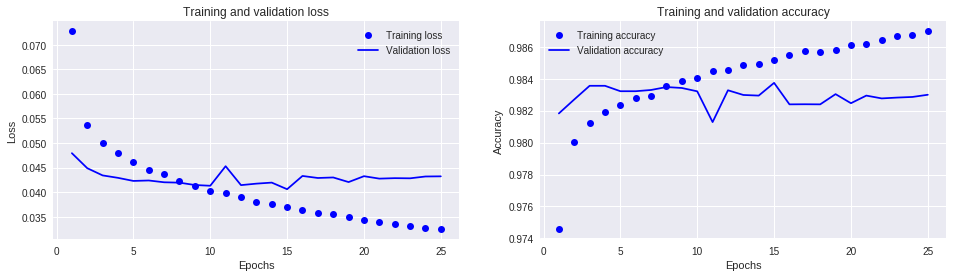

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 30s 941us/step
([0.041728641095170126, 0.9831218198588438], 0.9893760547270857)
